In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pickle as pk

Import Keras and tensorflow

In [3]:
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, Cropping2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

Using TensorFlow backend.


In [14]:
class DCGAN(object):
    def __init__(self, load_state =False, img_rows=900, img_cols=1200, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model
        if load_state:
            try:
                self.load_dcgan()
            except IOError:
                print('Previous state not saved, beginning with fresh state.')

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.6
        
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(BatchNormalization(momentum=0.9))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(BatchNormalization(momentum=0.9))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=2, padding='same'))
        self.D.add(BatchNormalization(momentum=0.9))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(depth*16, 5, strides=2, padding='same'))
        self.D.add(BatchNormalization(momentum=0.9))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.6
        depth = 64
        dim1 = 29
        dim2 = 38
        
        self.G.add(Dense(dim1*dim2*depth*16, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim1, dim2, depth*16)))
        self.G.add(Dropout(dropout))

        
        self.G.add(Conv2DTranspose(depth*8, 5, strides = 2, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(depth*4, 5, strides = 2, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        
        self.G.add(Conv2DTranspose(depth*2, 5, strides = 2, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        
        self.G.add(Conv2DTranspose(depth, 5, strides = 2, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(1, 5, strides = 2, padding='same'))
        self.G.add(Cropping2D(cropping=((14,14),(8,8))))
        self.G.add(Activation('tanh'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM

    def save_dcgan(self):
        model_type = ['D', 'G', 'AM','DM']
        for m in model_type:
            model = getattr(self, m)
            # serialize model to JSON
            with open(m+".json", "w") as f: f.write(model.to_json())
            # serialize weights to HDF5
            model.save_weights(m+"_weights.h5")
            
    def load_dcgan(self):
        model_type = ['D', 'G', 'AM','DM']
        for m in model_type:
            model = getattr(self, m)
            # load json and create model
            with open(m+'.json', 'r') as f: model = model_from_json(f.read())
            # load weights into new model
            model.load_weights(m+"_weights.h5")

In [8]:
class DustDCGAN(object):
    def __init__(self,load_state=False):
        #load list of dust maps
        dust_maps=[]
        with open('/global/homes/k/kmaylor/cori/Maps_and_Makers/Planck_dust_cuts_353GHz.pk','rb') as f:
            while True:
                try:
                    dust_maps.extend(pk.load(f))
                except EOFError:
                    break
        
        self.img_rows,self.img_cols = np.shape(dust_maps[0]) 
        self.channel = 1
        
        #normalize dust maps across entire set
        dmin = np.min(dust_maps)
        dmax = np.max(dust_maps)
        self.x_train = (dust_maps - dmin)/(dmax-dmin)
        
        # don't need the unormalized maps
        del dust_maps
        
        #format the training data, for 2d images keras expects one dim to be the num of channels
        #first dim is number of training samples, then image shape, then channels
        self.x_train=np.array(self.x_train)
        self.x_train = self.x_train.reshape(-1, self.img_rows,\
            self.img_cols, 1).astype(np.float32)
        #initialize the discriminator, adversarial models and the generator
        self.DCGAN = DCGAN(load_state=load_state)
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=25, save_interval=0):
        for i in range(train_steps):
            # First train the discriminator with correct labels
            # Randomly select batch from training samples
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            # Generate fake images from generator
            noise = np.random.normal(loc=0., scale=1., size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            # Combine true and false sets with correct labels and train discriminator
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)
            # Now train the adversarial network
            # Create new fake images labels as if they are from the training set
            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            # Generate log messages
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            if i%50==0:
                print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.DCGAN.save_dcgan()
                    noise_input = np.random.normal(loc=0., scale=1., size=[16, 100])
                    filename = "fake_sims_%d.png" % step
                    self.plot_images(filename=filename, samples=noise_input.shape[0],noise=noise_input)

    def plot_images(self, filename=None, fake=True, samples=16, noise=None):
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if filename!=None:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()
            
    


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 450, 600, 64)      1664      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 450, 600, 64)      0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 450, 600, 64)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 225, 300, 128)     204928    
_________________________________________________________________
batch_normalization_19 (Batc (None, 225, 300, 128)     512       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 225, 300, 128)     0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 225, 300, 128)     0         
__________

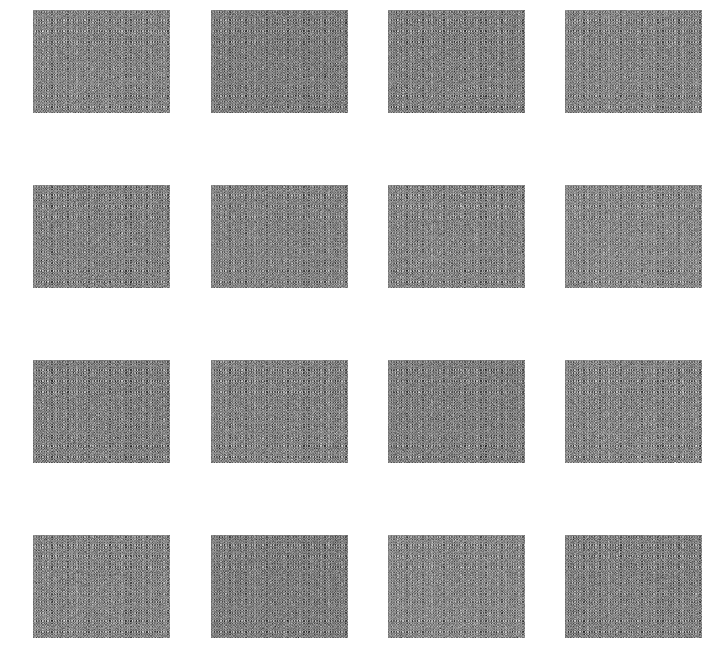

TypeError: plot_images() got an unexpected keyword argument 'save2file'

In [15]:
dust_gan = DustDCGAN(load_state=True)
#dust_gan.train(train_steps=2000, batch_size=32, save_interval=500)
dust_gan.DCGAN.save_dcgan()
dust_gan.plot_images(fake=True)
dust_gan.plot_images(fake=False, save2file=True)


